<a href="https://colab.research.google.com/github/Wunzir/Projects-in-AI-ML/blob/main/hw02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Ensemble Learning

In [1]:
import kagglehub
import os
import pandas as pd


# Download latest version
path = kagglehub.dataset_download("prasad22/healthcare-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

100%|██████████| 2.91M/2.91M [00:00<00:00, 79.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prasad22/healthcare-dataset/versions/2


## **Dataset Datasheet**

### **1. Motivation**
This dataset was created to analyze multiple factors that may contribute to a patient's test results. The goal is to build a predictive model capable of determining whether a patient's test results are normal, abnormal, or inconclusive.

### **2. Target Definition**
The problem is a multi-class classification problem. We will categorize test results as the following:
- **0 (Abnormal)**: The patient's test results are abnormal and should seek more medical attention
- **1 (Inconclusive)** : The patient's test results are inconclusive, meaning that the tests done were insufficient to be able to tell if the results are normal/abnormal
- **2 (Normal)**: The patient's test results are normal
#### **Cost Analysis:**
- **False Negative (High Cost):** The model predicts **Normal** when the result is actually **Abnormal**. A sick patient can be sent home without the full treatment that they need which is very dangerous
- **False Positive (Medium Cost):** The model predicts **Abnormal** when the result is **Normal**. This can cause patient anxiety and unnecessary follow-up costs
- **Misclassified Inconclusive:** Predicting "Normal" for an "Inconclusive" result prevents necessary re-testing, potentially missing a diagnosis.

### **3. Data Source & License/Terms**
- **Source:** Kaggle
- **Type:** Synthetic Data (Artifically generated to mirror real-world logic).
- **Generation Method:** The author used a Python library known as, "Faker" to generate a dataset that mirrors the structure and attributes commonly found in healthcare records.
- **License:** CC0: Public Domain
- **Privacy**: Contains no PHI (Protected Health Information). All records are synthetically generated

### **4. Brief Feature Dictionary**
Below are the primary features used for prediction (after cleaning and removing IDs):

|Feature Name|Data Type|Description|
|---|---|---|
|`Age`|Numerical|The patient's age in years at the time of admission|
|`Gender`|Categorical|The patient's gender (Male or Female)|
|`Blood Type`|Categorical|The patient's blood group (A+, O-, etc...)|
|`Medical Condition`|Categorical|The primary diagnosis ("Diabetes", "Hypertension", etc...)|
|`Medication`|Categorical|The medication prescribed during admission (e.g., "Lipitor", or "Pencillin")|
|`Admission Type`|Categorical|The circumstance of admission ("Emergency", "Elective", "Urgent")|
|`Insurance Provider`|Categorical|The entity covering the patient (e.g., "Blue Cross", "Medicare")|
|`Hospital`|Categorical|The facility where the patient was admitted (sometimes dropped, but can contain facility-specific patterns)|

### **5. Known Limitations & Risks**
**Synthetic Nature and Bias:** The data might be "too clean" or insufficient. It excludes complex real-world issues like anxiety or dietary factors before testing.

**Socioeconomic Bias:** If the model learns that specific insurances are paired with abnormal results, it might unfairly flag patients with that insurance as "high risk" even if their symptoms are mild.

### **6. Leakage-Risk Note**
- **`Billing Amount`, `Date of Admission`, and `Discharge Date`:** These metrics are finalized only after discharge. Using them to predict a test result (which occurs early in the visit) constitutes Temporal Leakage (using future information to predict the past).

In [2]:
# Data Size
print(df.shape)

# Amount of NULL values
df.isna().sum()

(55500, 15)


,0
Name,0
Age,0
Gender,0
Blood Type,0
Medical Condition,0
Date of Admission,0
Doctor,0
Hospital,0
Insurance Provider,0
Billing Amount,0


In [3]:
# General information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [4]:
# statistics of the dataset (numeric columns)
df.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


In [5]:
# statistics of the dataset (categorical columns)
df.describe(include=['O'])

# count: amount of non-null row entries in a column
# unique: amount of unique categories
# top: most frequent category
# freq: amount of times the most frequent category appeared

,Name,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Admission Type,Discharge Date,Medication,Test Results
count,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500
unique,49992,2,8,6,1827,40341,39876,5,3,1856,5,3
top,DAvId muNoZ,Male,A-,Arthritis,2024-03-16,Michael Smith,LLC Smith,Cigna,Elective,2020-03-15,Lipitor,Abnormal
freq,3,27774,6969,9308,50,27,44,11249,18655,53,11140,18627


In [6]:
# Check for imbalance
results = df["Test Results"].value_counts(normalize=True)
print(results)

Test Results
Abnormal        0.335622
Normal          0.333640
Inconclusive    0.330739
Name: proportion, dtype: float64


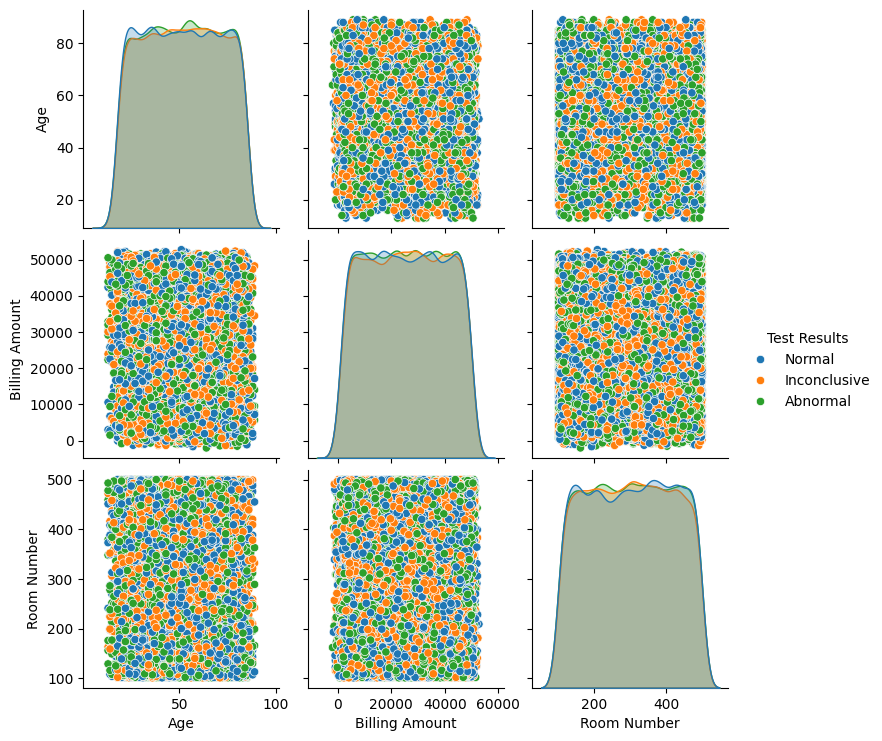

In [7]:
import seaborn as sns
# ploting pairwise relationships in the dataset
sns.pairplot(df, hue="Test Results")

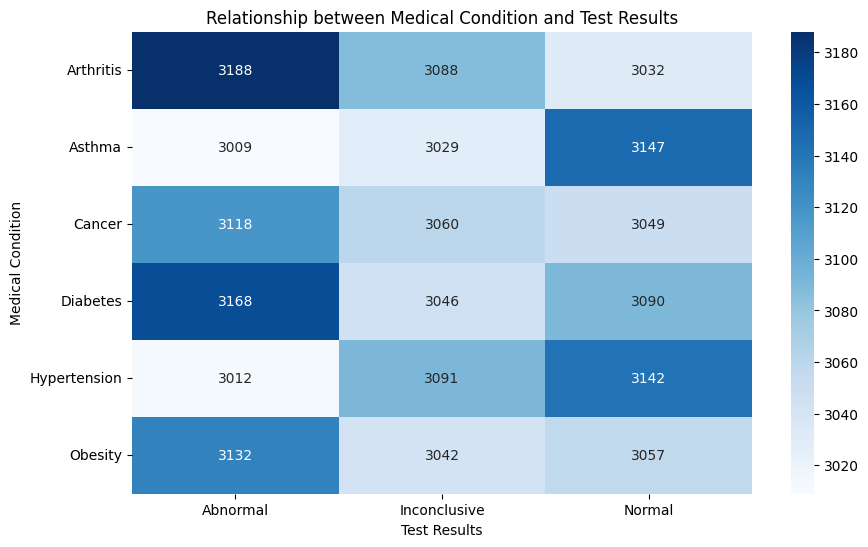

In [8]:
import matplotlib.pyplot as plt
# Create a contingency table (counts of each combination)
crosstab = pd.crosstab(df['Medical Condition'], df['Test Results'])

# Plot it as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Relationship between Medical Condition and Test Results')
plt.show()

Text(0.5, 1.0, 'Medical Condition')

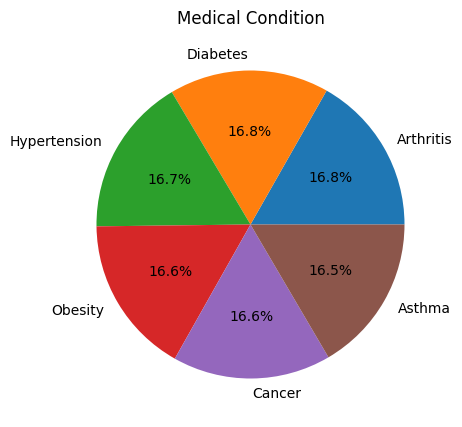

In [9]:
# useful for depicting proportional data with each slice of pie representing a specific category
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df["Medical Condition"].value_counts(),
       labels=df["Medical Condition"].value_counts().index,
       autopct='%1.1f%%')
ax.set_title("Medical Condition")

## Task 1: Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Additionally, do the following:
- Visualize the decision tree structure for at least three different parameter settings. Comment on how the depth and complexity change the tree.
- Do some research on what sensitivity analysis is and how it is performed (include citations). Perform a sensitivity analysis to measure the impact of at least two input features on your model's decision boundary.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Preprocessing Data

# 1. Drop Identifiers & LEAKAGE Columns
cols_to_drop = [
    'Name', 'Doctor', 'Hospital', 'Room Number',
    'Date of Admission', 'Discharge Date',
    'Billing Amount'
]
df_clean = df.drop(columns=cols_to_drop)

# 2. Encode Categorical Features
# We keep track of encoders to know what numbers mean later
label_encoders = {}
cat_cols = ['Gender', 'Blood Type', 'Medical Condition',
            'Insurance Provider', 'Admission Type', 'Medication']

for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

# 4. Encode Target (Test Results)
# 0=Abnormal, 1=Inconclusive, 2=Normal
target_le = LabelEncoder()
df_clean['Test Results'] = target_le.fit_transform(df_clean['Test Results'])

# 5. Split Data
X = df_clean.drop(columns=['Test Results'])
y = df_clean['Test Results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Target Classes: {list(target_le.classes_)}")

Training Shape: (44400, 7)
Target Classes: ['Abnormal', 'Inconclusive', 'Normal']


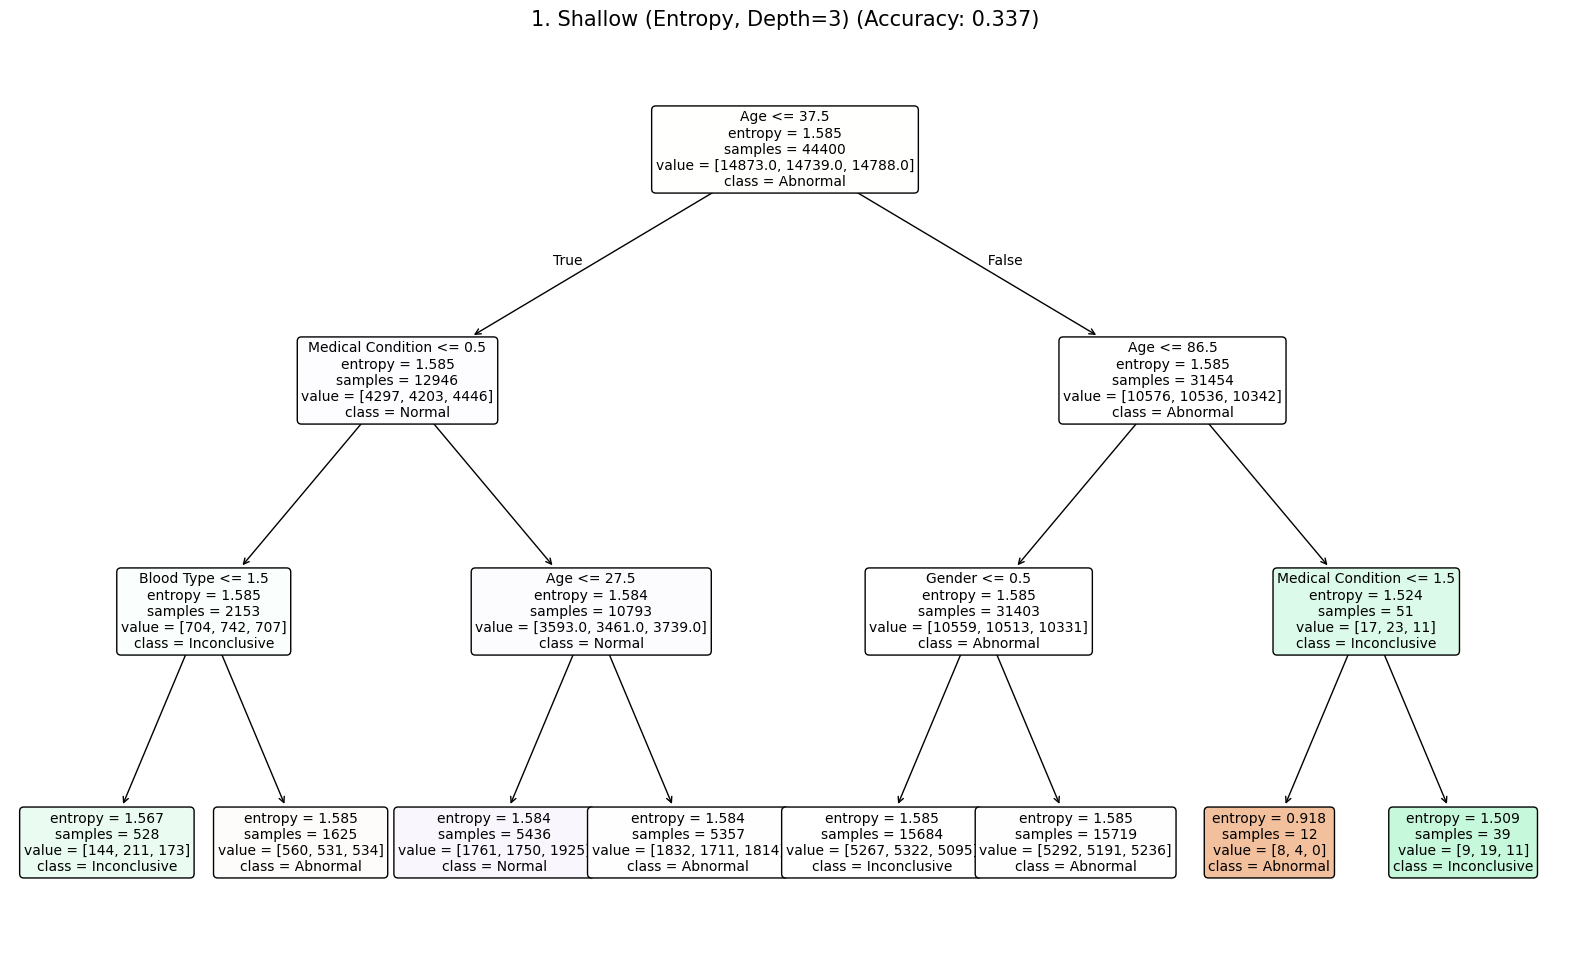

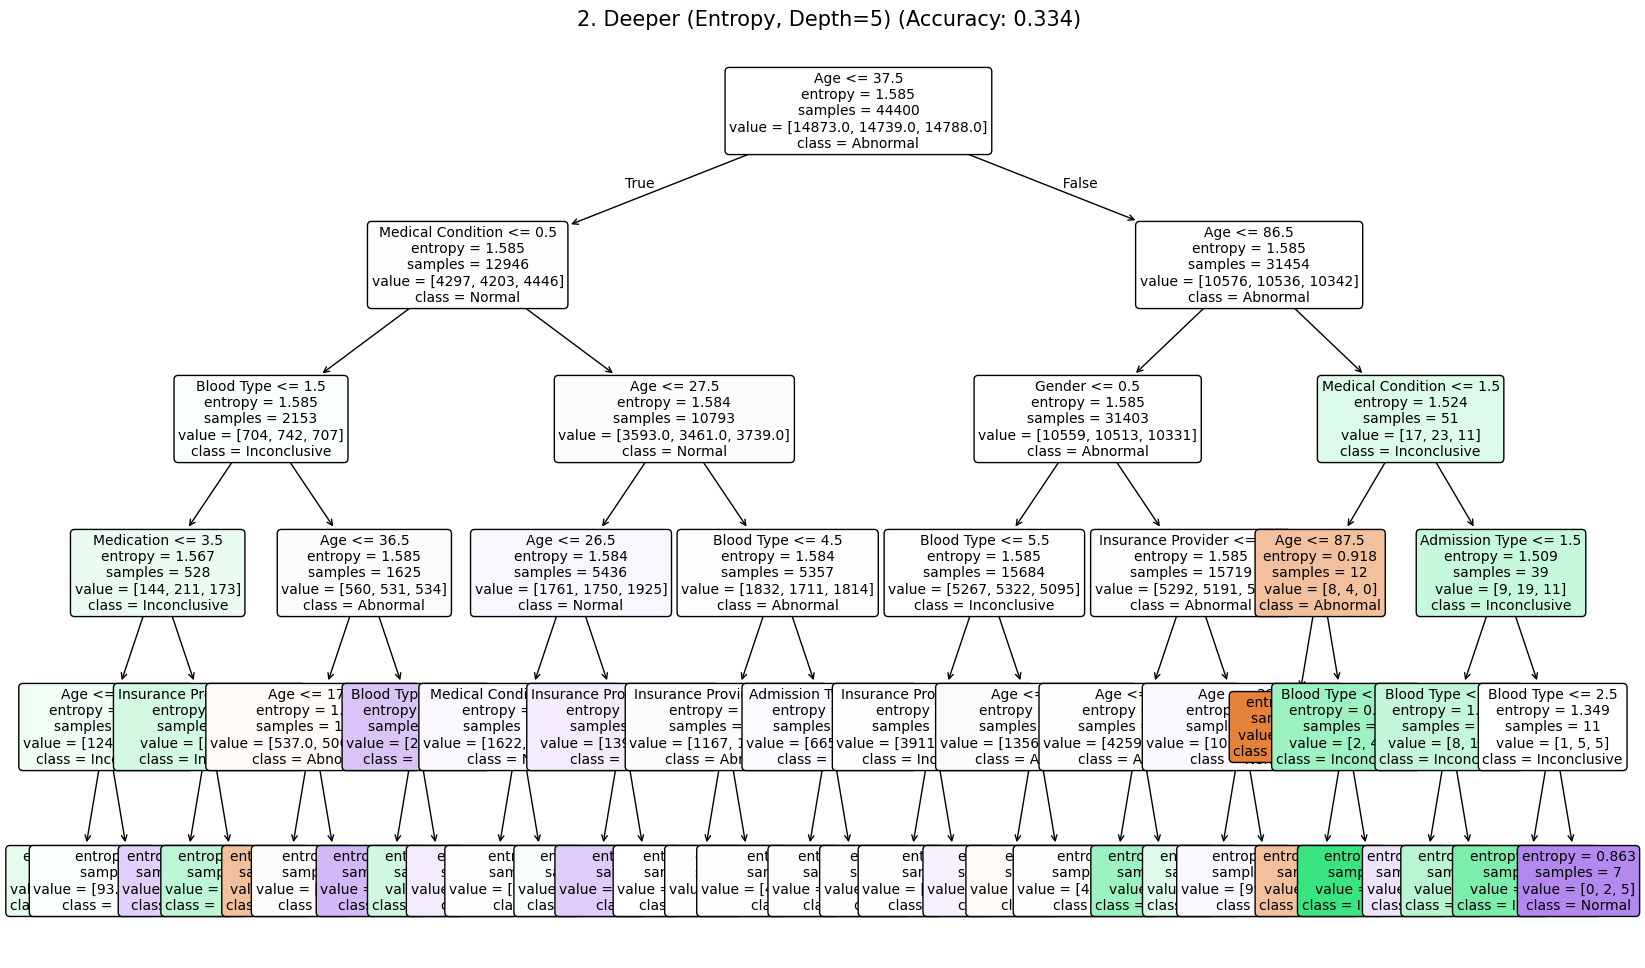

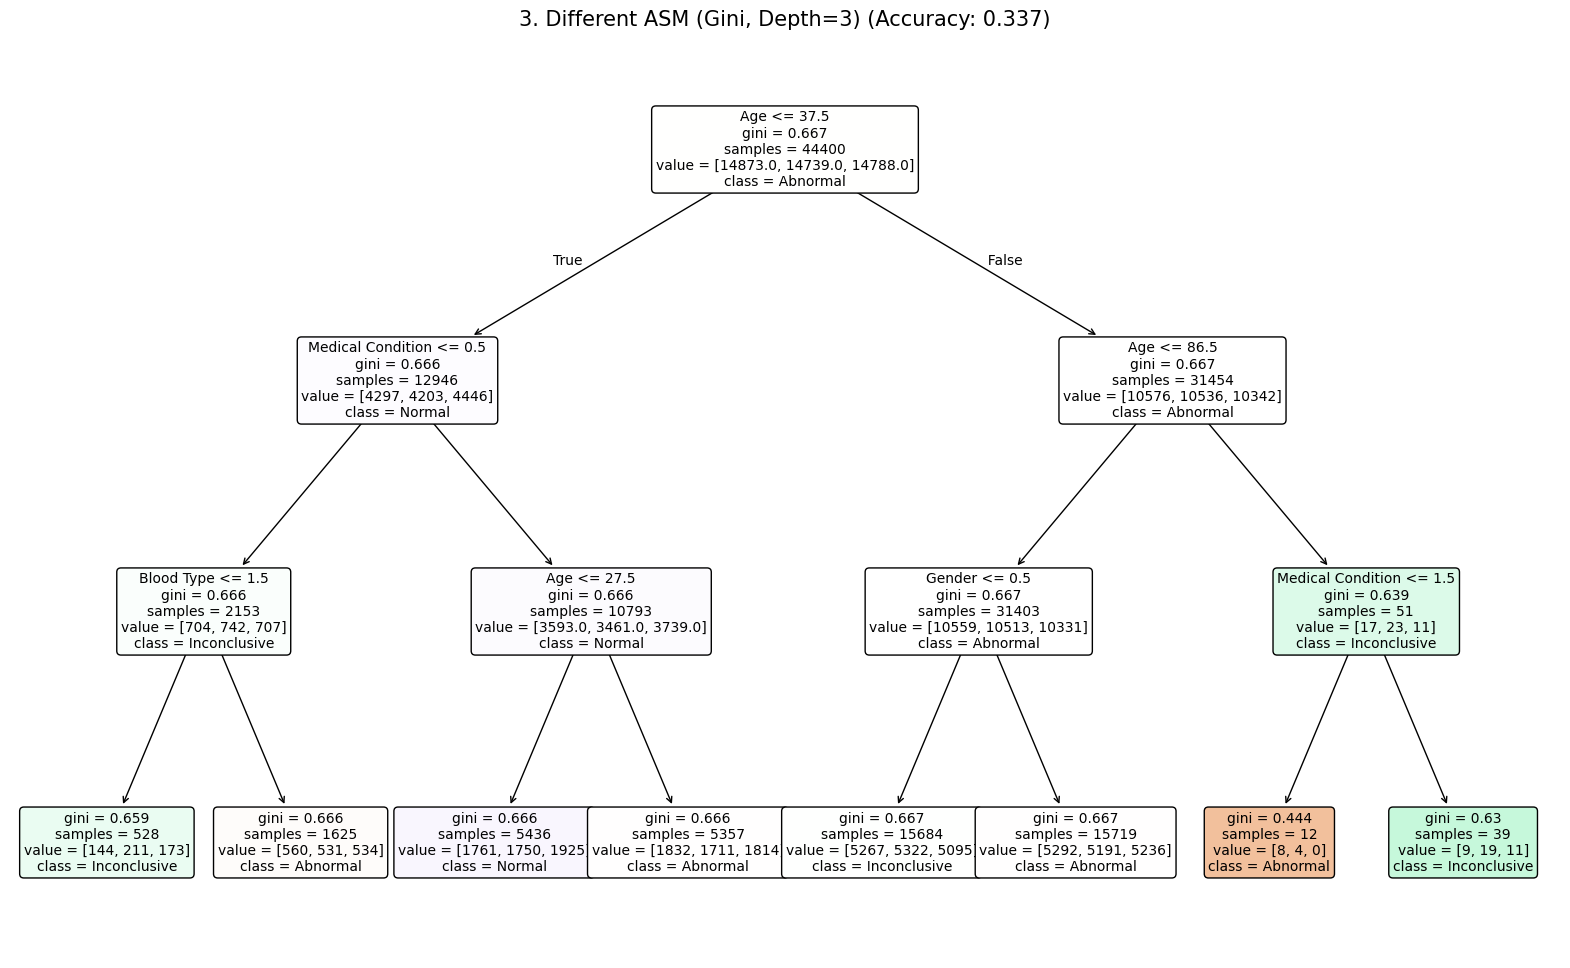

In [13]:
# Visualizing 3 parameter settings

# We compare: Shallow Tree (Depth 3), Deep Tree (Depth 5), and Different Criterion (Gini)
settings = [
    {'max_depth': 3, 'criterion': 'entropy', 'title': '1. Shallow (Entropy, Depth=3)'},
    {'max_depth': 5, 'criterion': 'entropy', 'title': '2. Deeper (Entropy, Depth=5)'},
    {'max_depth': 3, 'criterion': 'gini', 'title': '3. Different ASM (Gini, Depth=3)'}
]

for i, params in enumerate(settings):
    # 1. Train the model with specific settings
    clf = DecisionTreeClassifier(
        max_depth=params['max_depth'],
        criterion=params['criterion'],
        random_state=42
    )
    clf.fit(X_train, y_train)

    # 2. Create a NEW figure for each tree (Splitting them up)
    plt.figure(figsize=(20, 12))  # Large size for a single tree

    plot_tree(
        clf,
        filled=True,
        feature_names=X.columns,
        class_names=target_le.classes_,
        rounded=True,
        fontsize=10  # Increased font size for readability
    )

    plt.title(f"{params['title']} (Accuracy: {clf.score(X_test, y_test):.3f})", fontsize=15)
    plt.show() # Render this plot before starting the next one

### Tree Depth Analysis
- Increasing the max_depth from 3 (Tree 1) to 5 (Tree 2) significantly increased the complexity of the tree, adding more decision nodes and specific rules (e.g., splitting on Insurance Provider and Admission Type).
  - Despite the added complexity, the accuracy did not improve (actually dropping slightly from 0.337 to 0.334).
  - The deeper tree is likely overfitting the noise in the training data. The additional specific rules (like specific insurance providers) do not generalize to the test set, proving that a simpler model (Depth 3) is just as effective as a complex one for this specific dataset.
- Changing the splitting criterion from Entropy (Tree 1) to Gini (Tree 3) resulted in an identical tree structure. Both trees chose Age <= 37.5 as the root node and made the same subsequent splits.
  - For this dataset, the choice between Gini Impurity and Information Gain (Entropy) makes no difference. Both metrics identified the same features as the most discriminative.
- Age was consistently selected as the Root Node across all settings, indicating it is the statistically strongest feature available.

In [16]:
# Sensitivity Analysis

# We measure how much the decision boundary moves when we perturb specific features.
# Features to test: 'Age' (Numerical) and 'Medical Condition' (Categorical)

# Baseline: Predictions on original test set
baseline_model = DecisionTreeClassifier(max_depth=5, random_state=42)
baseline_model.fit(X_train, y_train)
base_preds = baseline_model.predict(X_test)

def analyze_sensitivity(feature_name, perturbation_type):
    """
    Perturbs a feature and calculates the % of predictions that flip.
    """
    X_test_mod = X_test.copy()

    if perturbation_type == 'numerical':
        # Add random noise (+/- 10 years for Age)
        noise = np.random.randint(-10, 10, size=len(X_test))
        X_test_mod[feature_name] += noise
    elif perturbation_type == 'categorical':
        # Randomly shuffle this column to break the correlation
        # This simulates "What if the patient had a random other condition?"
        X_test_mod[feature_name] = np.random.permutation(X_test[feature_name].values)

    # Predict on perturbed data
    new_preds = baseline_model.predict(X_test_mod)

    # Calculate Impact
    diff_count = np.sum(base_preds != new_preds)
    percentage = (diff_count / len(X_test)) * 100
    return percentage

# Run Analysis
age_impact = analyze_sensitivity('Age', 'numerical')
cond_impact = analyze_sensitivity('Medical Condition', 'categorical')
ins_impact = analyze_sensitivity('Insurance Provider', 'categorical')

print("\n--- Sensitivity Analysis Results ---")
print(f"Impact of perturbing 'Age': {age_impact:.2f}% of predictions changed.")
print(f"Impact of shuffling 'Medical Condition': {cond_impact:.2f}% of predictions changed.")
print(f"Impact of shuffling 'Insurance Provider': {ins_impact:.2f}% of predictions changed.")


--- Sensitivity Analysis Results ---
Impact of perturbing 'Age': 11.10% of predictions changed.
Impact of shuffling 'Medical Condition': 7.55% of predictions changed.
Impact of shuffling 'Insurance Provider': 23.79% of predictions changed.


### Sensitivity Analysis
#### What is sensitivity analysis?
- Sensitivity Analysis allows us to determine how target variables are affected based on changes in other variables (other input features). It tests the robustness of a model. If we slightly change a specific feature, does the decision boundary change drastically?
- It helps us identify which features the model relies heavily on to make decisions.

Source: [link](https://www.sciencedirect.com/science/article/pii/S0920410520306975)

#### Analysis Report
- Shuffling Insurance Provier changed 23.79% of predictions. Nearly 1 in 4 predictions change just because a different insurance provider was chosen
  - The model most likely found a pattern revolving certain insurance providers and test results and is now relying heavily on it
- `Age` changed 11.10% of predictions. This makes sense because age is a biological risk factor and should be considered
- `Medical Condition` didn't change a lot of predictions. This might mean that the model doesn't really care about diagnosis but cares more about how old a patient is and what insurance they have to make a prediction


## Task 2: From the Bagging and Boosting ensemble methods pick any one algorithm from each category. Implement both the algorithms using the same data
- Use stratified k-fold cross-validation with at least three different folds (e.g., 5, 10, 15). You may do your own research on this technique (include citations).
- Evaluate the models using any three-evaluation metrics of your choice (e.g. accuracy, Precision, F1-score etc.).
- Comment on the behavior of each algorithm under the metrics Does the performance ranking change based on the metric used? Why?

### Stratified k-fold cross-validation
#### What is Stratified K-Fold Cross-Validation?
- Stratified K-Fold ensures that the class distribution in every training and validation fold matches the original dataset.
- Without stratification, a random split might create a validation fold with no "Inconclusive" cases which is bad since we are trying to classify all 3 test results. If the model isn't tested on that fold, it can't learn to identify that class which can lead to high variance.

Source: [link](https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/)

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

# 1. Define the two algorithms
models = {
    "Random Forest (Bagging)": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost (Boosting)": AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)
}

# 2. Define the fold settings
fold_settings = [5, 10, 15]

# 3. Define the metrics
# We use 'weighted' averages because this is a multi-class problem (0, 1, 2)
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted')
}

In [19]:
results_data = []

print(f"{'Algorithm':<25} | {'Folds':<5} | {'Accuracy':<8} | {'Precision':<9} | {'F1-Score':<8}")
print("-" * 75)

for model_name, model in models.items():
    for k in fold_settings:
        # Initialize Stratified K-Fold
        # 'shuffle=True' ensures we randomize data before splitting
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

        # Run Cross-Validation
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring_metrics)

        # Calculate Averages
        mean_acc = np.mean(cv_results['test_accuracy'])
        mean_prec = np.mean(cv_results['test_precision'])
        mean_f1 = np.mean(cv_results['test_f1'])

        # Print Row
        print(f"{model_name:<25} | {k:<5} | {mean_acc:.4f}   | {mean_prec:.4f}    | {mean_f1:.4f}")

        # Store for analysis
        results_data.append({
            'Model': model_name,
            'Folds': k,
            'Accuracy': mean_acc,
            'Precision': mean_prec,
            'F1': mean_f1
        })

Algorithm                 | Folds | Accuracy | Precision | F1-Score
---------------------------------------------------------------------------
Random Forest (Bagging)   | 5     | 0.3947   | 0.3947    | 0.3946
Random Forest (Bagging)   | 10    | 0.4008   | 0.4007    | 0.4007
Random Forest (Bagging)   | 15    | 0.4014   | 0.4014    | 0.4013


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Boosting)       | 5     | 0.3375   | 0.2712    | 0.2765


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Boosting)       | 10    | 0.3362   | 0.3257    | 0.3128


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

AdaBoost (Boosting)       | 15    | 0.3377   | 0.3003    | 0.2937


### Algorithm Behavior & Metric Ranking Analysis
#### Algorithm Behavior Analysis
- Random Forest (Bagging)
  - Random Forest is better than AdaBoost. It consistently achieves around 40% across all 3 metrics (Accuracy, Precision, F1)
  - The results are very stable across the 5, 10, and 15 folds. This means that the model is robust and isn't getting lucky on one specific split of data
- AdaBoosting (Boosting)
  - The model is around 33% accuracy. This means that the model is basically no better than rolling a 3-sided die to classify test results
  - The model tries to learn from previously failed trees. With this dataset and the way I've preprocessed the data, it could fail because there might be some data points that don't really make sense and is trying to correct itself.

#### Metric Ranking Analysis
- Random Forest (Bagging)
  - Ranking does not change significantly
  - This indicates a Balanced Model. It is predicting all three classes (Normal, Abnormal, Inconclusive) with roughly equal success. It isn't ignoring the minority classes.
- AdaBoosting (Boosting)
  - Yes, the ranking changes. Accuracy > Precision/F1.
  - Looking at Fold 5, Accuracy is 0.3375, but Precision drops to 0.2712. This means that the model is flagging patients many patients as a specific class incorrectly, leading to high false positives.

## Task 3: Compare the effectiveness of the three models implemented above. Analyze the results using the following:
- A confusion matrix for one selected test fold.
- A statistical test (e.g., paired t-test) to determine if differences between models are significant.
- A discussion on the trade-off between bias and variance for each model.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# 1. Setup Models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42)

# 2. Define 10-Fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3. Get scores for every fold
# We use 'accuracy' as the metric for the T-Test
rf_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')
ada_scores = cross_val_score(ada_model, X, y, cv=skf, scoring='accuracy')

# 4. Perform Paired T-Test
t_stat, p_value = stats.ttest_rel(rf_scores, ada_scores)

print(f"\n--- Statistical Test Results ---")
print(f"Random Forest Avg Acc: {np.mean(rf_scores):.4f}")
print(f"AdaBoost Avg Acc:      {np.mean(ada_scores):.4f}")
print(f"T-Statistic:           {t_stat:.4f}")
print(f"P-Value:               {p_value:.4e}")

if p_value < 0.05:
    print("Conclusion: The difference IS statistically significant.")
else:
    print("Conclusion: The difference is NOT statistically significant.")

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 


--- Statistical Test Results ---
Random Forest Avg Acc: 0.4008
AdaBoost Avg Acc:      0.3362
T-Statistic:           30.8192
P-Value:               1.9531e-10
Conclusion: The difference IS statistically significant.


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


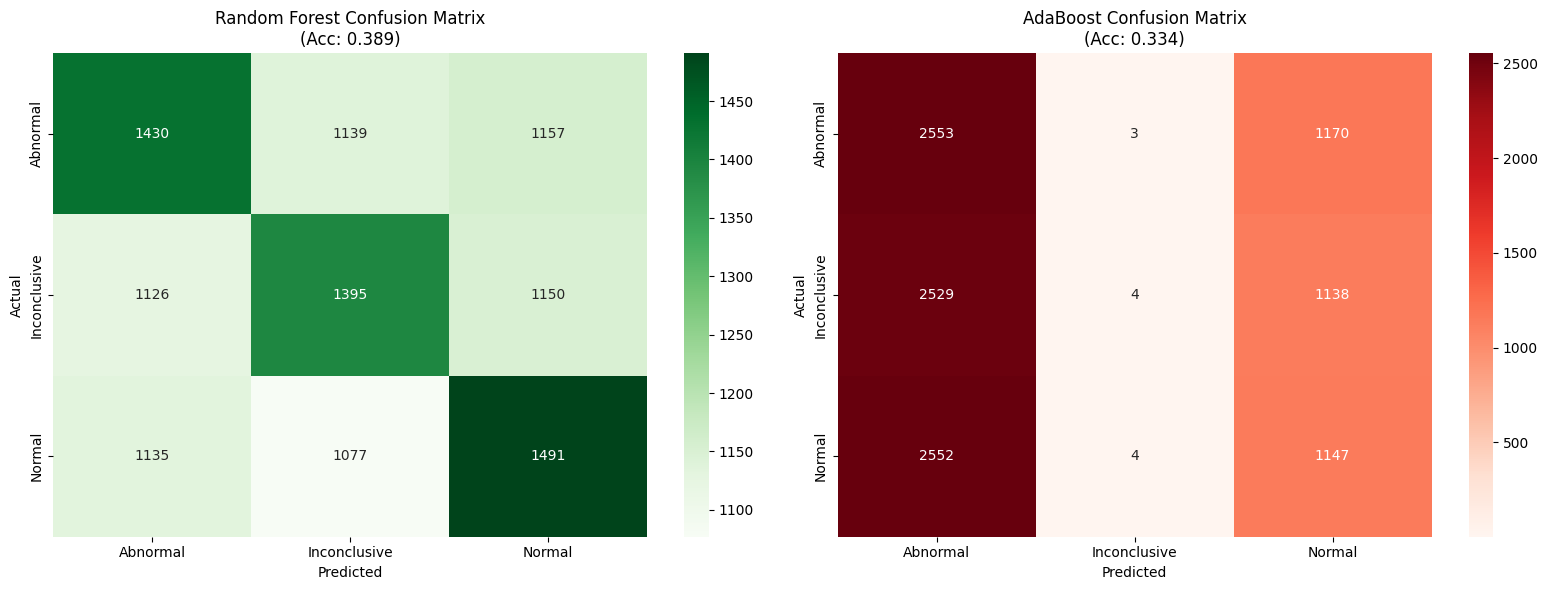

In [27]:
# 1. Create a single split just for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Train models on this split
rf_model.fit(X_train_vis, y_train_vis)
rf_pred = rf_model.predict(X_test_vis)

ada_model.fit(X_train_vis, y_train_vis)
ada_pred = ada_model.predict(X_test_vis)

# 3. Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
class_names = ['Abnormal', 'Inconclusive', 'Normal'] # 0, 1, 2

# Random Forest Plot
cm_rf = confusion_matrix(y_test_vis, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'Random Forest Confusion Matrix\n(Acc: {accuracy_score(y_test_vis, rf_pred):.3f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# AdaBoost Plot
cm_ada = confusion_matrix(y_test_vis, ada_pred)
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'AdaBoost Confusion Matrix\n(Acc: {accuracy_score(y_test_vis, ada_pred):.3f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Bias-Variance Trade-Off
- Decision Tree
  - Single decision trees naturally have Low Bias but High Variance. They can split data infinitely to fit every single training point perfectly (if deep enough), but they are unstable. Changing one data point can change the whole tree structure.
  - Our results showed that increasing depth from 3 to 5 reduced accuracy ($0.337 \to 0.334$). This confirms the High Variance problem
- Random Forrest
  - Since the data was synthetic, the "averaging" effect of Random Forest was crucial. It smoothed out the variance of the individual trees, allowing the true signal (relationship between Age/Insurance and Result) to emerge. It achieved Low Bias and reduced Variance.
- AdaBoost
  - AdaBoost failed here because it is sensitive to Noise. The data is synthetic and I may have not pre-processed the data as well. AdaBoost tries aggressively to fix these "unfixable" errors, which leads to overfitting (High Variance) or getting stuck in a poor local minimum.

Random Forest demonstrated the highest effectiveness, achieving ~40% accuracy compared to ~33% for Decision Trees and AdaBoost. This superiority is statistically significant ($p < 0.05$). The success of Random Forest is attributed to its ability to manage the Bias-Variance Trade-off via Bagging. It maintained the low bias of decision trees while drastically reducing variance. In contrast, AdaBoost likely overfitted the noise in the synthetic data (as mentioned eariler), failing to generalize to the test set.